In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
import matplotlib.font_manager
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d  
import seaborn as sns  #A statistical plotting library
from sklearn.cluster import KMeans
from math import comb
from sklearn.preprocessing import PolynomialFeatures
#from kneed import KneeLocator
from mayavi import mlab
plt.style.use('seaborn')
np.random.seed(42)

In [2]:
DF = pd.read_csv('2_music.csv',header = None)
DF.shape

(1059, 70)

In [3]:
#Defining a class to process and divide the dataframe in to the req. numpy form.
class pro_split_df:
    def __init__(self,df,batch_size):
        self.df   = df                 #The original dataframe.
        self.batch_size = batch_size   #Number of samples to be choosen from the dataframe.
        
        
    #A function to convert dataframe in to numpy array.
    #Training data set input vectors is stored in a matrix of dim Nxd. d -> no. of features, N -> No. of examples
    def df_to_np(self,dat_fr):
        In_df = dat_fr.loc[:,0:67]    #Choosing the columns belonging to the input feature vectors.
        L_df  = dat_fr.loc[:,68:69]          #Choosing the columns belonging to the labels.
        return In_df.to_numpy(),L_df.to_numpy()
    
    #A function for Random row selection of required batch size of a Pandas dataframe
    def Rand_Choose(self):
        return self.df.sample(n = self.batch_size, random_state=42)
    
    
    def df_split(self,df):
        #Splits the array in to 70,20,10.
        return np.split(df,[int(.7*len(df)), int(.8*len(df))])
    
    #A function to split the batches in to training and data.   
    def tr_val_test_split(self):
        dat_fr = self.Rand_Choose()        #Randomly choosing batchsize number of samples from the org. dataframe.
        tr_df,ts_df,val_df = self.df_split(dat_fr) #Splits the datframe in to train, val and test.
        x_tr,y_tr = self.df_to_np(tr_df)      #conversion to numpy
        x_val,y_val = self.df_to_np(val_df)
        x_test,y_test = self.df_to_np(ts_df)
        return x_tr,x_val,x_test,y_tr,y_val,y_test
        
    

In [4]:
#N=500
batch500 = pro_split_df(DF,500)  #An instace of class sep_data.
x_tr500,x_val500,x_test500,y_tr500,y_val500,y_test500 = batch500.tr_val_test_split()

#N=1000
batch1000 = pro_split_df(DF,1000)  #An instace of class sep_data.
x_tr1000,x_val1000,x_test1000,y_tr1000,y_val1000,y_test1000 = batch1000.tr_val_test_split()

In [16]:
#%%writefile Linear_Regression_Class.py 
#Defining a class that given our choice of basis function returns the optimal paramters.
#Polynomial and Gaussian Basis for the regression task at hand is employed.

class Do_Regression:
    #This class will return the optimal paramters by using the basis function of our choice.
    def __init__(self,X,y,Gb_Hp,Pb_Hp,basisname,regularisation):
        self.X = X  #Input vectors of training dataset as a numpy array Nxd.
        self.y = y
        self.Gb_Hp = Gb_Hp
        self.D = None  #An hyperparameter which detrmines the spread of gaussian basis functions.
        self.s = None  #An hyperparameter which detrmines the spread of gaussian basis functions.
        self.Mean_Mat = None     #The mean vector array-(D-1)xd. Each row represents a mean vector.
        self.Pb_Hp = Pb_Hp  #List of hyper
        self.Erms = None
        self.phi = None     #Attribute used to store the design matrix used for testing
        self.pred =None     #Attribute to store the prediction values
        self.basisname = basisname
        self.hp_comb_gbf = None  #An attribute for the combination of hyperparameters.
        self.phi_bar = None 
        self.regularisation = regularisation
           
    #KMeans implementation for finding the mean of the various basis functions initially.
    #Number of clusters eqauls the number of gaussian basis functions being used.
    def K_Clustering(self):
        #Dictionary of the arguments for scikit.KMeans
        KMeans_args = {
        "init" :"random",
        "n_init" : 10,
        "max_iter" : 300,
        "random_state" : 0,
        } 
        k = self.D - 1   #Number of clusters equals D-1.
        kmeans =  KMeans(n_clusters = k , **KMeans_args)
        kmeans.fit(self.X)
        labels = kmeans.labels_
        #The mean vector matrix is stored 
        self.Mean_Mat = kmeans.cluster_centers_
        
        
    def Gaussian_hyperparamter_comb(self):
        hp_list_gbf = list(self.Gb_Hp.values()) # a list of all possible combinations of hyperparameters
        self.hp_comb_gbf = [(d,s) for d in hp_list_gbf[0] for s in hp_list_gbf[1]]    
        
 
    def Gaussian_DesMat(self):
        #Returns the output design matrix made of gbf of the input x.
        phi_gauss = np.zeros((len(self.X), self.D))
        #Finding the mean of clusters,
        self.K_Clustering()   #Calling this function will update the attribute associated with Mean Matrix.
        
        ones_vector = np.ones((len(self.X))) #To be added to the first column of the matrix
        phi_gauss[:,0] = ones_vector
        sigma2 = self.s**2
        expo = ( -2*(self.X@(self.Mean_Mat.T)) + np.reshape(np.sum(self.X**2, axis=1), (len(self.X), -1)) ) + np.sum(self.Mean_Mat**2, axis=1)
        phi_gauss[:,1:] = np.exp(-expo/sigma2)
        return phi_gauss
    
    def GaussDM_test_Data(self):
        #Returns the output design matrix made of gbf of the input x of test data.
        phi_gauss = np.zeros((len(self.X), self.D))
        ones_vector = np.ones((len(self.X))) #To be added to the first column of the matrix
        phi_gauss[:,0] = ones_vector
        sigma2 = self.s**2
        expo = ( -2*(self.X@(self.Mean_Mat.T)) + np.reshape(np.sum(self.X**2, axis=1), (len(self.X), -1)) ) + np.sum(self.Mean_Mat**2, axis=1)
        phi_gauss[:,1:] = np.exp(-expo/sigma2)
        return phi_gauss
        
       
    
    def Poly_DesMat(self):
        #Returns the output design matrix made of gbf of the input x and degree m.
        d = len(x[0])
        #m is the maximum degree of monomials being used for polynomial basis function.
        poly = PolynomialFeatures(degree = self.m)  #Using the inbuilt function from sklearn.
        phi_poly = poly.fit_transform(self.X)
        
        
        #Plotting for better understanding
#         phi_flat = phi_poly.flatten()
#         xarr = np.arange(1,phi_flat.size+1,1)
#         plt.scatter(xarr,phi_flat)
#         plt.show()
        return phi_poly
    
    def get_design_mat(self):
        if self.basisname == 'Gaussian':
            PHI = self.Gaussian_DesMat()   #Updates the design matrix with gaussian basis functions.
        if self.basisname == 'Polynomial':
            PHI = self.Poly_DesMat()        #Updates the design matrix with polynomial basis functions.
#         if basisname == 'Linear':
#             PHI = self.X
        return PHI 
    
    def Reg_term(self,MU):
        deg = self.D-1
        sigma2 = self.s**2
        self.phi_bar = np.eye(self.D)   #For Quadratic regualriser.
        if self.regularisation == 'Tikhonov':
            for i in range(deg):
                for j in range(i):
                    self.phi_bar[i+1][j+1] = np.exp(-np.sum((MU[j]-MU[i])**2)/sigma2)
                    self.phi_bar[j+1][i+1] = self.phi_bar[i+1][j+1]
#             expo = np.reshape(np.sum(MU**2,axis=1),(len(MU),-1)) + np.sum(MU**2,axis=1) - 2*(MU@MU.T)
#             self.phi_bar = np.exp(-expo/2*self.s*self.s)
        
        
        
    
    def LinearRegressor(self,lam):  
        #Takes as input the labels of the training data and the hyperparamter lambda
        erms_tr ={}
        W = {}
        MU ={}
        if self.basisname == 'Gaussian':
            self.Gaussian_hyperparamter_comb()  #Updates the attribute for the combination of hyperparameters.
            for (dim,sigma) in self.hp_comb_gbf:
                self.D,self.s = dim,sigma        #Updates the attribute for hyperparameters of gbf
                PHI = self.get_design_mat()
                MU[str(dim)+' '+ str(sigma)] = self.Mean_Mat
                self.Reg_term(self.Mean_Mat)                  #Updates the attribute self.phi_bar
                w = LA.inv(PHI.T@PHI + lam*self.phi_bar)@(PHI.T@self.y)
                #Error for training data
                erms_tr[str(dim)+' '+ str(sigma)] = self.erms(w,0)
                W[str(dim)+ ' ' + str(sigma)] = w
            
        if self.basisname == 'Polynomial':
            for degree in Pb_Hp:
                self.m = degree
                PHI = self.get_design_mat()
                self.Reg_term()   #Updates the attribute self.phi_bar
                w = np.linalg.inv(PHI.T@PHI + lam*self.phi_bar)@(PHI.T@self.y)
                W['degree'] = w
        return W,MU,erms_tr
    
    
    def erms(self,w,f):
        if f==1:  #for testing
            self.phi = self.GaussDM_test_Data()
        if f==0:  #For training
            self.phi = self.get_design_mat()
        self.pred = self.phi@w
        error_arr = (self.pred - self.y)
        #plt.scatter(self.y,self.pred,c='g')
        return LA.norm(error_arr,axis=0)/np.sqrt(len(self.y))
#     
    
    
    def test_set_error(self,W,MU):  #W is the optimal parameters estimated from training
        #Run this function only after training and on testing on validation and test dataset.
        erms_test = {}
        self.Gaussian_hyperparamter_comb()
        for (dim,sigma) in self.hp_comb_gbf:
            self.D,self.s = dim,sigma
            w = W[str(dim)+' '+ str(sigma)]
            mu = MU[str(dim)+' '+ str(sigma)]
            self.Mean_Mat = mu
            erms_test[str(dim)+' '+ str(sigma)] = self.erms(w,1)
        return erms_test
    
    def plot_pred_vs_true(self,w,mu,sig):
        true_val = self.y
        self.s = sig
        self.D = len(w)
        self.Mean_Mat = mu
        phi = self.GaussDM_test_Data()
        pred = phi@w
        fig,(ax1,ax2) = plt.subplots(figsize=(20,16),nrows=2,ncols=1)
        ax1.scatter(true_val[:,0],pred[:,0],c='b')
        ax1.set_xlabel('true value')
        ax1.set_ylabel('predicted value')
        ax1.set_title('Plot for True Value vs Predicted Value of the best model for test dataset with E_rms = 13.18')
        ax2.scatter(true_val[:,1],pred[:,1],c='b')
        ax2.set_xlabel('true value')
        ax2.set_ylabel('predicted value')
        ax2.set_title('Plot for True Value vs Predicted Value of the best model for test dataset with E_rms = 39.20')
        plt.show()

        

In [17]:
#Hyperparamters for gaussian and polynomial.
Gb_Hp = {'Dim': [10,25,50,100,200,340], 'sigma' : [1,10,50,100]}
Pb_Hp = [2,3,6,9] 
#An instance of the class regression for training.
do_reg = Do_Regression(x_tr500,y_tr500,Gb_Hp,Pb_Hp,'Gaussian','Quadratic')  #An instance for the regression class.

In [18]:
W_opt,MU_opt,erms_tr_data = do_reg.LinearRegressor(0) 


In [19]:
erms_tr_data

{'10 1': array([17.59289869, 49.50335361]),
 '10 10': array([15.80906199, 46.71631325]),
 '10 50': array([15.64238935, 46.92535003]),
 '10 100': array([15.66054839, 46.91062702]),
 '25 1': array([17.19158644, 48.1152345 ]),
 '25 10': array([15.23314306, 43.45098154]),
 '25 50': array([15.01008387, 42.76556607]),
 '25 100': array([15.01306217, 42.80278884]),
 '50 1': array([15.91075193, 44.73704588]),
 '50 10': array([13.82173242, 40.69338118]),
 '50 50': array([14.24404187, 39.84118882]),
 '50 100': array([14.37943316, 40.11575971]),
 '100 1': array([ 7320.51843646, 15961.02132758]),
 '100 10': array([11.99636073, 33.57593822]),
 '100 50': array([12.12053039, 33.54210809]),
 '100 100': array([12.1272635 , 33.69792096]),
 '200 1': array([ 9.61842675, 29.631186  ]),
 '200 10': array([ 8.40537991, 23.15496998]),
 '200 50': array([ 8.72148775, 22.85825364]),
 '200 100': array([ 8.75112402, 22.77713215]),
 '340 1': array([1.73063061, 6.06396184]),
 '340 10': array([1.90150074, 5.90151563]),

In [20]:
#Validation dataset error estimation for finding the optimal values of hyperparameters.
val_reg = Do_Regression(x_val500,y_val500,Gb_Hp,Pb_Hp,'Gaussian','Quadratic')
erms_val_data = val_reg.test_set_error(W_opt,MU_opt)
# erms_val_df = pd.DataFrame(list(erms_val_data.items()),columns = ['Degree and Sigma','Erms'])
erms_val_data

{'10 1': array([19.56469554, 52.71482221]),
 '10 10': array([19.06237553, 48.54219517]),
 '10 50': array([19.24162466, 51.62143244]),
 '10 100': array([19.2415203 , 51.77861939]),
 '25 1': array([19.49664221, 52.5887048 ]),
 '25 10': array([19.17495047, 45.0072098 ]),
 '25 50': array([19.52685108, 45.40368364]),
 '25 100': array([19.55333324, 45.66526323]),
 '50 1': array([19.448183  , 52.32671808]),
 '50 10': array([19.32245576, 45.60726478]),
 '50 50': array([19.19715924, 45.61026361]),
 '50 100': array([19.20255353, 45.7000986 ]),
 '100 1': array([15887.55226296, 30521.68345988]),
 '100 10': array([18.61082088, 42.23540656]),
 '100 50': array([22.19040783, 46.99861553]),
 '100 100': array([22.45664349, 47.55538374]),
 '200 1': array([23.54320204, 56.09986424]),
 '200 10': array([20.04156568, 43.43266515]),
 '200 50': array([24.12636036, 54.18847577]),
 '200 100': array([24.52119177, 55.73028656]),
 '340 1': array([23.07819718, 68.55778305]),
 '340 10': array([26.20903235, 50.0024163

In [21]:
#Test dataset error estimation.
test_reg = Do_Regression(x_test500,y_test500,Gb_Hp,Pb_Hp,'Gaussian','Quadratic')
erms_test_data = test_reg.test_set_error(W_opt,MU_opt)
# erms_val_df = pd.DataFrame(list(erms_val_data.items()),columns = ['Degree and Sigma','Erms'])
erms_test_data

{'10 1': array([16.33642033, 47.39522372]),
 '10 10': array([14.90150132, 45.2045417 ]),
 '10 50': array([14.92449692, 49.1052453 ]),
 '10 100': array([14.91765273, 49.19699588]),
 '25 1': array([16.25500535, 47.46528839]),
 '25 10': array([15.50571209, 42.72238271]),
 '25 50': array([15.16842525, 46.30358145]),
 '25 100': array([15.06413086, 46.74262181]),
 '50 1': array([16.29554438, 46.97290321]),
 '50 10': array([13.56770165, 42.47495925]),
 '50 50': array([14.53128409, 43.3890861 ]),
 '50 100': array([14.53900697, 43.6033566 ]),
 '100 1': array([19.88214215, 48.960055  ]),
 '100 10': array([13.18246291, 39.2039429 ]),
 '100 50': array([14.34503904, 45.70570564]),
 '100 100': array([14.2139652 , 46.80821507]),
 '200 1': array([16.36149422, 48.94370057]),
 '200 10': array([12.51192887, 37.84633913]),
 '200 50': array([12.40927478, 46.24519706]),
 '200 100': array([12.44306096, 47.55334923]),
 '340 1': array([22.38404415, 62.18666592]),
 '340 10': array([14.12568762, 46.23990608]),
 

In [22]:
w_plot = W_opt['100 10']
mu_plot = MU_opt['100 10']


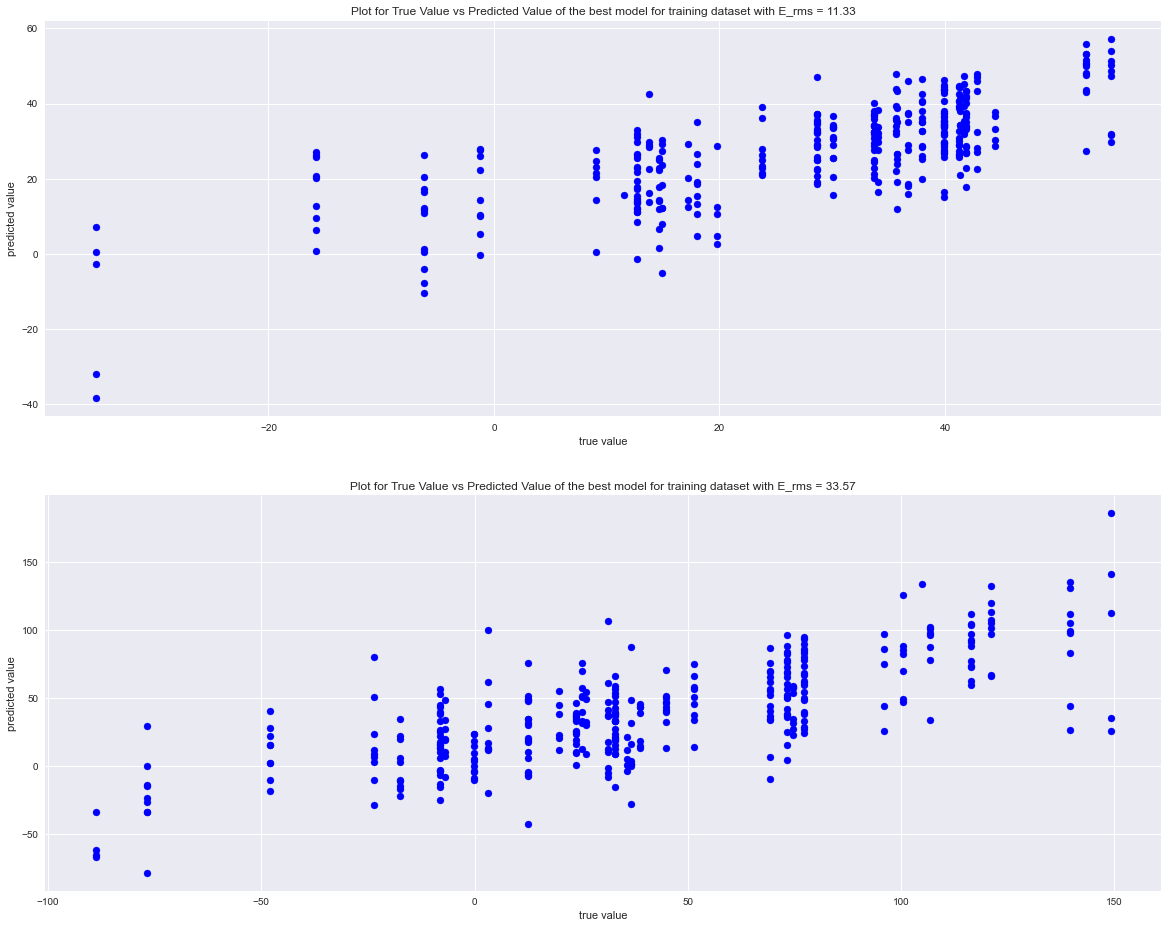

In [12]:
#Plot for training data
do_reg.plot_pred_vs_true(w_plot,mu_plot,10)

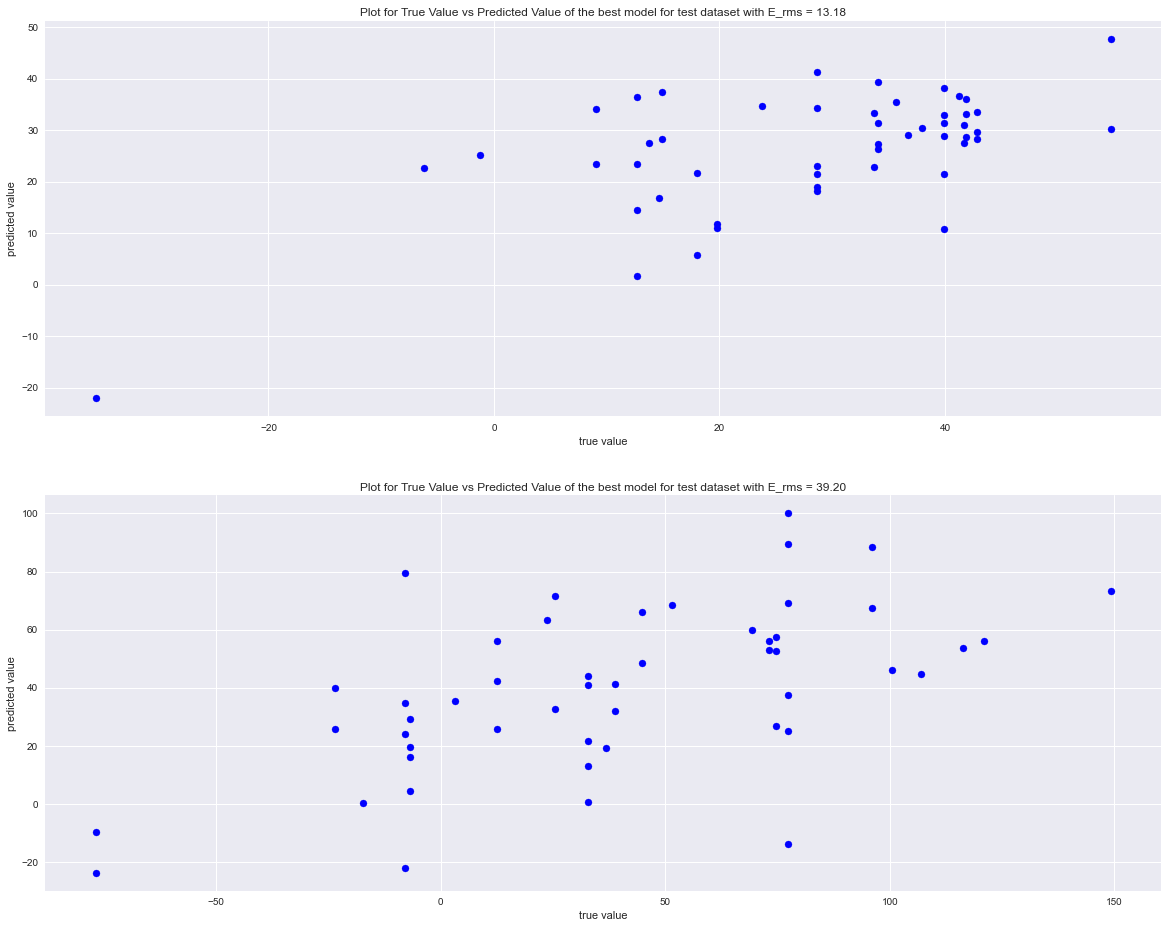

In [23]:
test_reg.plot_pred_vs_true(w_plot,mu_plot,10)

In [24]:
#Effect of quadratic regularisation on dimesnsion 100 and sigma =1
#Fitting the training datasets
Gb_Hp_reg = {'dim':[340],'sigma':[10]}
regl_tr_reg = Do_Regression(x_tr500,y_tr500,Gb_Hp_reg,Pb_Hp,'Gaussian','Quadratic')
lam_lst = [10e-05,10e-03,10e-01,0,10,10e+3,10e+5]
W_opt_reg ={}
MU_opt_reg ={}
erms_tr_reg ={}
for lam in lam_lst:
    W_opt_reg[str(lam)],MU_opt_reg[str(lam)],erms_tr_reg[str(lam)] = regl_tr_reg.LinearRegressor(lam) 
erms_tr_reg

{'0.0001': {'340 10': array([1.97731235, 5.96853904])},
 '0.01': {'340 10': array([ 5.79476024, 13.55926445])},
 '1.0': {'340 10': array([12.27768712, 35.94410677])},
 '0': {'340 10': array([1.90150074, 5.90151563])},
 '10': {'340 10': array([14.98481711, 43.4134606 ])},
 '10000.0': {'340 10': array([21.92988381, 55.4278165 ])},
 '1000000.0': {'340 10': array([32.75926008, 63.3061733 ])}}

In [25]:
#Validation dataset error estimation for varying lambda
regl_val_reg = Do_Regression(x_val500,y_val500,Gb_Hp_reg,Pb_Hp,'Gaussian','Quadratic')
erms_val_qreg={}
for lam in lam_lst:
    erms_val_qreg[str(lam)] = regl_val_reg.test_set_error(W_opt_reg[str(lam)],MU_opt_reg[str(lam)])
# erms_val_df = pd.DataFrame(list(erms_val_data.items()),columns = ['Degree and Sigma','Erms'])
erms_val_qreg

{'0.0001': {'340 10': array([21.77644581, 46.14188249])},
 '0.01': {'340 10': array([18.91941328, 43.57593392])},
 '1.0': {'340 10': array([18.39950127, 42.86234994])},
 '0': {'340 10': array([26.20903235, 50.00241637])},
 '10': {'340 10': array([18.58097153, 45.88566532])},
 '10000.0': {'340 10': array([22.4193611 , 59.02706008])},
 '1000000.0': {'340 10': array([31.4207469 , 67.81806953])}}

In [26]:
#Validation dataset error estimation for varying lambda
regl_test_reg = Do_Regression(x_test500,y_test500,Gb_Hp_reg,Pb_Hp,'Gaussian','Quadratic')
erms_test_qreg={}
for lam in lam_lst:
    erms_test_qreg[str(lam)] = regl_test_reg.test_set_error(W_opt_reg[str(lam)],MU_opt_reg[str(lam)])
# erms_val_df = pd.DataFrame(list(erms_val_data.items()),columns = ['Degree and Sigma','Erms'])
erms_test_qreg

{'0.0001': {'340 10': array([11.35810781, 41.7331407 ])},
 '0.01': {'340 10': array([12.08954133, 37.75954699])},
 '1.0': {'340 10': array([13.56302889, 38.78744457])},
 '0': {'340 10': array([14.12568762, 46.23990608])},
 '10': {'340 10': array([15.10060689, 43.18939847])},
 '10000.0': {'340 10': array([21.4215032 , 53.02862179])},
 '1000000.0': {'340 10': array([31.97989977, 61.44816235])}}

In [28]:
#Effect of Tikhonov regularisation on dimesnsion 100 and sigma =1
tregl_tr_reg = Do_Regression(x_tr500,y_tr500,Gb_Hp_reg,Pb_Hp,'Gaussian','Tikhonov')
lam_lst = [10e-03,10e-01,0,10,10e+1,10e+3,10e+5]
W_opt_treg ={}
MU_opt_treg ={}
erms_tr_treg ={}
for lam in lam_lst:
    W_opt_treg[str(lam)],MU_opt_treg[str(lam)],erms_tr_treg[str(lam)] = tregl_tr_reg.LinearRegressor(lam) 
erms_tr_treg

{'0.01': {'340 10': array([2.3470202 , 6.52968671])},
 '1.0': {'340 10': array([11.23182755, 32.31365546])},
 '0': {'340 10': array([1.90150074, 5.90151563])},
 '10': {'340 10': array([15.43778117, 44.86092707])},
 '100.0': {'340 10': array([18.0409872 , 50.48701674])},
 '10000.0': {'340 10': array([32.0641297 , 62.60050978])},
 '1000000.0': {'340 10': array([33.10943567, 63.58906683])}}

In [29]:
#Validation dataset error estimation for varying lambda
tik_regl_val_reg = Do_Regression(x_val500,y_val500,Gb_Hp_reg,Pb_Hp,'Gaussian','Tikhonov')
erms_val_treg={}
for lam in lam_lst:
    erms_val_treg[str(lam)] = tik_regl_val_reg.test_set_error(W_opt_treg[str(lam)],MU_opt_treg[str(lam)])
# erms_val_df = pd.DataFrame(list(erms_val_data.items()),columns = ['Degree and Sigma','Erms'])
erms_val_treg

{'0.01': {'340 10': array([19.40790706, 44.16807756])},
 '1.0': {'340 10': array([18.21440102, 42.89647166])},
 '0': {'340 10': array([26.20903235, 50.00241637])},
 '10': {'340 10': array([18.59308212, 48.12448674])},
 '100.0': {'340 10': array([19.42614738, 53.44233788])},
 '10000.0': {'340 10': array([30.76844362, 67.07871612])},
 '1000000.0': {'340 10': array([31.73797315, 68.11512817])}}

In [30]:
#Validation dataset error estimation for varying lambda
tik_regl_test_reg = Do_Regression(x_test500,y_test500,Gb_Hp_reg,Pb_Hp,'Gaussian','Tikhonov')
erms_test_treg={}
for lam in lam_lst:
    erms_test_treg[str(lam)] = tik_regl_test_reg.test_set_error(W_opt_treg[str(lam)],MU_opt_treg[str(lam)])
# erms_val_df = pd.DataFrame(list(erms_val_data.items()),columns = ['Degree and Sigma','Erms'])
erms_test_treg

{'0.01': {'340 10': array([12.32932375, 38.92059036])},
 '1.0': {'340 10': array([12.9596598, 38.5286864])},
 '0': {'340 10': array([14.12568762, 46.23990608])},
 '10': {'340 10': array([14.89395993, 44.27606454])},
 '100.0': {'340 10': array([17.06122721, 48.29166814])},
 '10000.0': {'340 10': array([31.26828782, 60.72152798])},
 '1000000.0': {'340 10': array([32.33009257, 61.74924556])}}